In [1]:
# some basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from power_grid_model import LoadGenType
from power_grid_model import PowerGridModel, CalculationMethod, CalculationType, MeasuredTerminalType
from power_grid_model import initialize_array

In [2]:
# Only for plotting. AI generated. You can ignore this part.
def plot_profile(data, title, ylabel):
    p = np.asarray(data)
    nt, ncols = p.shape
    hours = np.linspace(0, 24, nt, endpoint=False)

    fig, axes = plt.subplots(1, ncols, figsize=(12, 3.5))
    axes = axes.flatten()

    # plot each profile in the 1x4 subplots (convert to MW for readability)
    for i in range(ncols):
        ax = axes[i]
        ax.plot(hours, p[:, i], marker="o", lw=2)
        ax.set_title(f"{title} {i+1}")
        ax.set_xlabel("Hour")
        ax.set_ylabel(ylabel)
        ax.grid(True)

    fig.tight_layout()
    plt.show()

# Topology and Component Data

More information on each attributes can be found in the documentation: https://power-grid-model.readthedocs.io/en/stable/user_manual/components.html

```
  [Source] (node 1)
      |
   (transformer id=6, u1=33kV -> u2=10kV)
      |
     Node 2  (load id=10)
      /  \
 (line7) (line9)
    /      \
 Node 3    Node 5
 (load id=11) (load id=13, is physically agenerator)
   |
 (line8)
   |
 Node 4
 (load id=12)
```

In [3]:
# node
node = initialize_array("input", "node", 5)
node["id"] = np.array([1, 2, 3, 4, 5])
node["u_rated"] = [33e3, 10e3, 10e3, 10e3, 10e3]

# transformer
transformer = initialize_array("input", "transformer", 1)
transformer["id"] = [6]
transformer["from_node"] = [1]
transformer["to_node"] = [2]
transformer["u1"] = [33e3]
transformer["u2"] = [10e3]
transformer["sn"] = [1e6]
transformer["uk"] = [0.05]
transformer["pk"] = [1e3]
transformer["i0"] = [1.0e-6]
transformer["p0"] = [0]
transformer["winding_from"] = [1]
transformer["winding_to"] = [1]
transformer["clock"] = [0]
transformer["tap_side"] = [0]
transformer["tap_pos"] = [3]
transformer["tap_nom"] = [0]
transformer["tap_min"] = [-5]
transformer["tap_max"] = [5]
transformer["tap_size"] = [330]

# line
line = initialize_array("input", "line", 3)
line["id"] = [7, 8, 9]
line["from_node"] = [2, 3, 2]
line["to_node"] = [3, 4, 5]
line["from_status"] = [1, 1, 1]
line["to_status"] = [1, 1, 1]
line["r1"] = 0.0162
line["x1"] = 0.089
line["c1"] = 0.45e-9
line["tan1"] = 0.0
line["i_n"] = 360

# load
sym_load = initialize_array("input", "sym_load", 4)
sym_load["id"] = [10, 11, 12, 13]
sym_load["node"] = [2, 3, 4, 5]
sym_load["status"] = [1, 1, 1, 1]
sym_load["type"] = LoadGenType.const_power
sym_load["p_specified"] = [1.0e6, 1.0e6, 1.0e6, 1.5e6]
sym_load["q_specified"] = [0.0, 0.0, 0.0, 0.0]

# source
source = initialize_array("input", "source", 1)
source["id"] = [0]
source["node"] = [1]
source["status"] = [1]
source["u_ref"] = [1.0]
source["sk"] = [1050e20]
source["z01_ratio"] = 3

# all
input_data = {
    "node": node,
    "line": line,
    "transformer": transformer,
    "sym_load": sym_load,
    "source": source
}

# Power Flow Example

In [4]:
n_timesteps = 10
sym_load_update = initialize_array("update", "sym_load", (n_timesteps, 4))
sym_load_update["id"] = [10, 11, 12, 13]
sym_load_update["p_specified"] = [
    # timestep 0 .. 9 (10 timesteps for a whole day)
    # columns: [load1, load2, load3, generation]
    [9.00e5, 7.00e5, 8.00e5,  0.00e0],   # night (low)
    [9.50e5, 7.50e5, 9.00e5,  0.00e0],   # early morning rising
    [1.05e6, 8.50e5, 1.10e6, -2.00e5],   # sunrise / small solar
    [1.25e6, 1.00e6, 1.50e6, -8.00e5],   # morning
    [1.50e6, 1.10e6, 1.80e6, -1.30e6],   # late morning
    [1.60e6, 1.15e6, 2.00e6, -1.80e6],   # midday (solar peak)
    [1.50e6, 1.20e6, 1.70e6, -1.40e6],   # afternoon
    [1.35e6, 1.40e6, 1.30e6, -6.00e5],   # late afternoon
    [1.10e6, 1.80e6, 1.00e6,  0.00e0],   # evening (residential peak, solar off)
    [9.50e5, 1.00e6, 9.00e5,  0.00e0],   # night (return to low)
]
sym_load_update["q_specified"] = sym_load_update["p_specified"] * 0.328684 # 0.328684 is power factor cos(phi)=0.95

update_data_pf = {
    "sym_load": sym_load_update
}

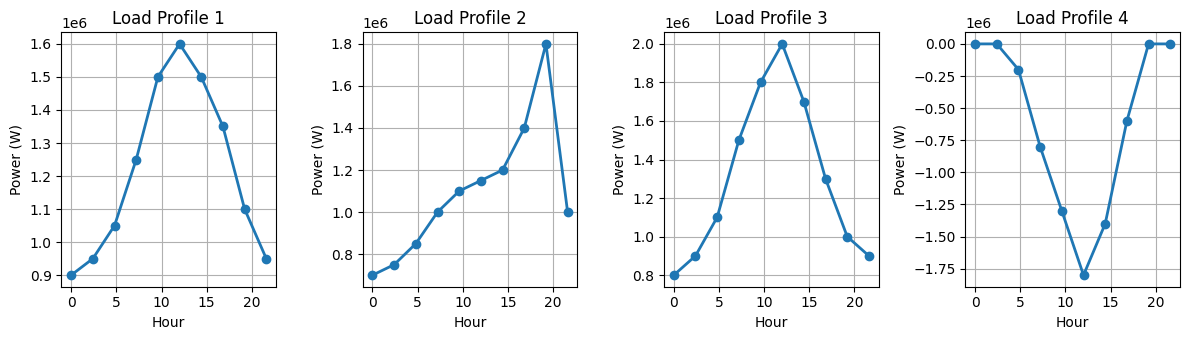

In [5]:
# Load Profile plot
plot_profile(data=update_data_pf["sym_load"]["p_specified"], title="Load Profile", ylabel="Power (W)")

## Calculate Power flow

In [6]:
try:
    model = PowerGridModel(input_data)
    output_pf = model.calculate_power_flow(update_data=update_data_pf, calculation_method=CalculationMethod.newton_raphson)
except Exception as e:
    print(f"Error occurred: {e.errors}, failed scenario: {e.failed_scenarios}")


In [7]:
print(f"Nodal voltages:")
print(pd.DataFrame(output_pf['node']['u_pu']))

Nodal voltages:
     0         1         2         3         4
0  1.0  0.916275  0.915529  0.915131  0.916275
1  1.0  0.910446  0.909619  0.909169  0.910446
2  1.0  0.904302  0.903318  0.902763  0.904403
3  1.0  0.899290  0.898018  0.897257  0.899693
4  1.0  0.894095  0.892610  0.891690  0.894754
5  1.0  0.898665  0.897059  0.896043  0.899573
6  1.0  0.897364  0.895885  0.895021  0.898072
7  1.0  0.882415  0.881016  0.880344  0.882724
8  1.0  0.865484  0.864005  0.863478  0.865484
9  1.0  0.902802  0.901842  0.901388  0.902802


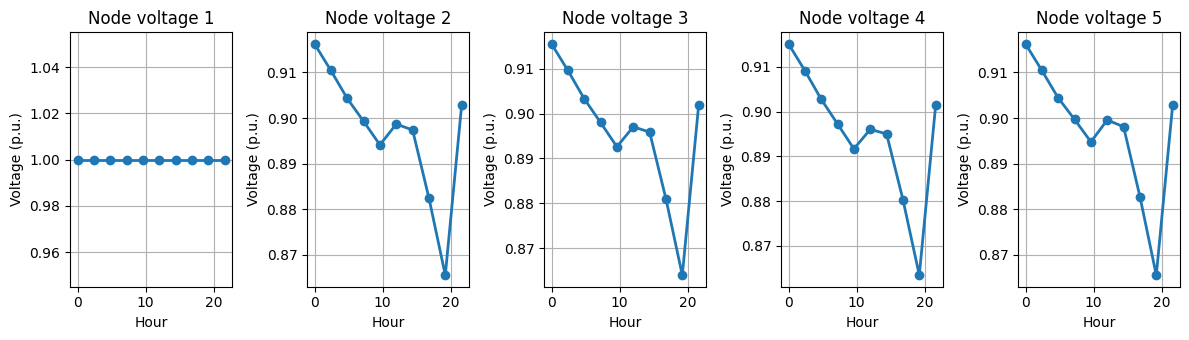

In [8]:
# Nodal Voltage
plot_profile(data=output_pf["node"]["u_pu"], title="Node voltage", ylabel="Voltage (p.u.)")

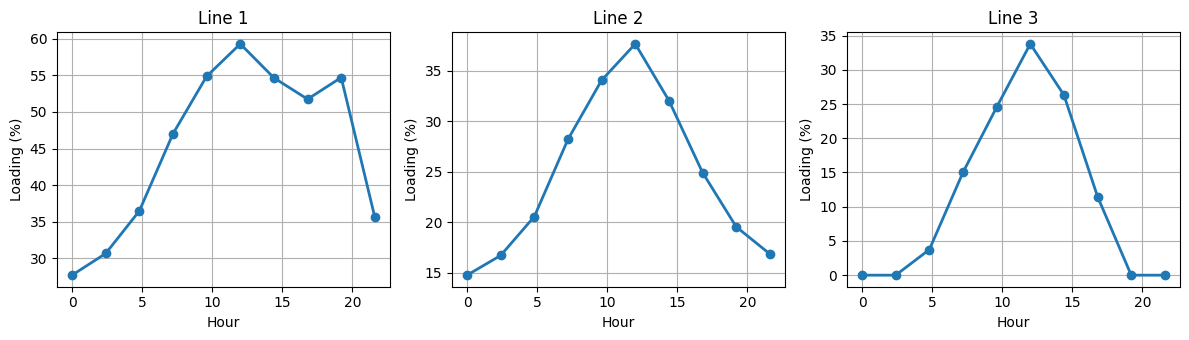

In [9]:
# Line Loading
plot_profile(data=output_pf["line"]["loading"] * 100, title="Line", ylabel="Loading (%)")

## Limit Violations

A system operator is not comfortable with a voltage as low as 0.89 p.u.
As per regulations voltage at all places should lie within 0.9-1.1 p.u.
The operator owns transmission and distributed transformers. It can use tap positions on the transformer to influence the grid operation. In this case, the voltage.

In [10]:
input_data_regulated = input_data.copy()
input_data_regulated["transformer"][ "tap_pos"] = [-2]  # change tap position to -2
try:
    model = PowerGridModel(input_data_regulated)
    output_pf = model.calculate_power_flow(update_data=update_data_pf, calculation_method=CalculationMethod.newton_raphson)
except Exception as e:
    print(f"Error occurred: {e.errors}, failed scenario: {e.failed_scenarios}")


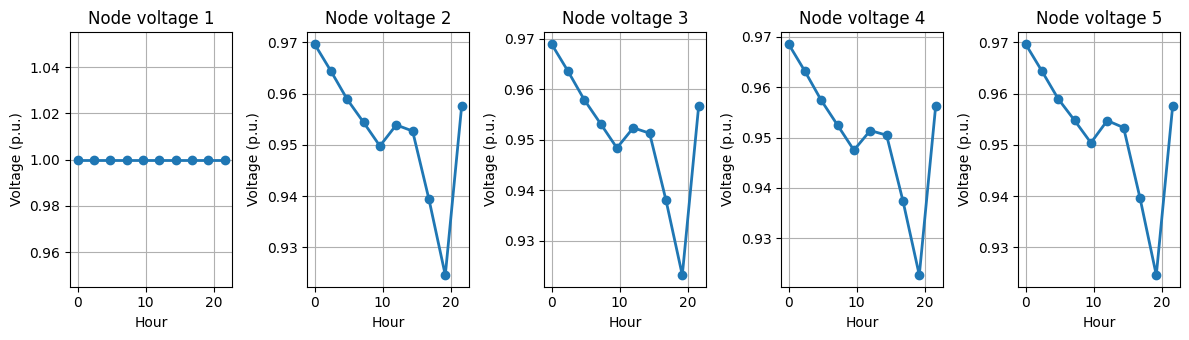

In [11]:
# Nodal Voltage
plot_profile(data=output_pf["node"]["u_pu"], title="Node voltage", ylabel="Voltage (p.u.)")

## Applications of Power Flow analysis

A complex formulation of such data is used to simulate different situations in grid. 
Many power grid related companies: TSO / DSO / generation companies / retailer etc use these calculations.
Some simulation examples are:
* Optimise tap positions of transformers in the grid.
* They can be used to do network planning. This can be traditionally laying of new cables or transformers. 
* EV, battery, solar growth simulations.
* Contingency analysis (eg. what if a certain component like a line or transformer fails? What is the effect on all customers?)
* Encourage market participation
* Offer specialized or dynamic contracts to customers
* Optimise flow of power for minimal grid loss
* Optimise flow based on cost of generation and loading

# State Estimation

## State Estimation related topology

In [12]:
input_data_se = input_data.copy()

sym_voltage_sensor = initialize_array("input", "sym_voltage_sensor", 3)
sym_voltage_sensor["id"] = [14, 15, 16]
sym_voltage_sensor["measured_object"] = [2, 3, 5]

sym_power_sensor = initialize_array("input", "sym_power_sensor", 6)
sym_power_sensor["id"] = [17, 18, 19, 20, 21, 22]
sym_power_sensor["measured_object"] = [6, 6, 7, 8, 12, 13]
sym_power_sensor["measured_terminal_type"] = [MeasuredTerminalType.branch_from, MeasuredTerminalType.branch_to,
                                              MeasuredTerminalType.branch_from, MeasuredTerminalType.branch_from,
                                              MeasuredTerminalType.load, MeasuredTerminalType.load]

input_data_se.update({
    "sym_voltage_sensor": sym_voltage_sensor,
    "sym_power_sensor": sym_power_sensor
})

## Measurement data

In [13]:
sym_voltage_sensor_update = initialize_array("update", "sym_voltage_sensor", (n_timesteps, 3))
sym_voltage_sensor_update["id"] = [14, 15, 16]
sym_voltage_sensor_update["u_measured"] = [
    [1.06, 1.05, 1.04],
    [1.03, 1.02, 1.00],
    [1.00, 0.99, 0.96],
    [0.97, 0.96, 0.93],
    [0.95, 0.94, 0.90],
    [0.92, 0.91, 0.88],
    [0.95, 0.94, 0.91],
    [0.99, 0.98, 0.94],
    [1.02, 1.01, 0.98],
    [1.04, 1.03, 1.01]
]
sym_voltage_sensor_update["u_measured"] *= 1e4  # convert to V
sym_voltage_sensor_update["u_sigma"] = 100

sym_power_sensor_update = initialize_array("update", "sym_power_sensor", (n_timesteps, 6))
sym_power_sensor_update["id"] = [17, 18, 19, 20, 21, 22]
sym_power_sensor_update["p_measured"] = [
    [5.0e5, -4.0e5, 3.0e5, 2.0e5, 1.0e6, 1.5e6],
    [4.5e5, -3.5e5, 2.5e5, 1.5e5, 9.5e5, 1.4e6],
    [4.0e5, -3.0e5, 2.0e5, 1.0e5, 9.0e5, 1.3e6],
    [3.5e5, -2.5e5, 1.5e5, 5.0e4, 8.5e5, 1.2e6],
    [3.0e5, -2.0e5, 1.0e5, 0.0e0, 8.0e5, 1.1e6],
    [2.5e5, -1.5e5, 5.0e4, -5.0e4, 7.5e5, 1.0e6],
    [3.0e5, -2.0e5, 1.0e5, 0.0e0, 8.0e5, 1.1e6],
    [3.5e5, -2.5e5, 1.5e5, 5.0e4, 8.5e5, 1.2e6],
    [4.0e5, -3.0e5, 2.0e5, 1.0e5, 9.0e5, 1.3e6],
    [4.5e5, -3.5e5, 2.5e5, 1.5e5, 9.5e5, 1.4e6]
]
sym_power_sensor_update["q_measured"] = [
    [1.64e5, -1.31e5, 9.84e4, 6.56e4, 3.28e5, 4.92e5],
    [1.48e5, -1.15e5, 8.20e4, 4.92e4, 3.12e5, 4.60e5],
    [1.31e5, -9.84e4, 6.56e4, 3.28e4, 2.95e5, 4.10e5],
    [1.15e5, -8.20e4, 4.92e4, 1.64e4, 2.62e5, 3.70e5],
    [9.84e4, -6.56e4, 3.28e4, 0.00e0, 2.30e5, 3.28e5],
    [8.20e4, -4.92e4, 1.64e4, -1.64e4, 1.97e5, 2.95e5],
    [9.84e4, -6.56e4, 3.28e4, 0.00e0, 2.30e5, 3.28e5],
    [1.15e5, -8.20e4, 4.92e4, 1.64e4, 2.62e5, 3.70e5],
    [1.31e5, -9.84e4, 6.56e4, 3.28e4, 2.95e5, 4.10e5],
    [1.48e5, -1.15e5, 8.20e4, 4.92e4, 3.12e5, 4.60e5]
]
sym_power_sensor_update["p_sigma"] = 10000
sym_power_sensor_update["q_sigma"] = 10000


update_data_se = {
    "sym_voltage_sensor": sym_voltage_sensor_update,
    "sym_power_sensor": sym_power_sensor_update
}

## Calculate State Estimation

In [14]:
try:
    model = PowerGridModel(input_data_se)
    output_se = model.calculate_state_estimation(update_data=update_data_se, calculation_method=CalculationMethod.newton_raphson)
except Exception as e:
    print(f"Error occurred: {e.errors}, failed scenario: {e.failed_scenarios}")

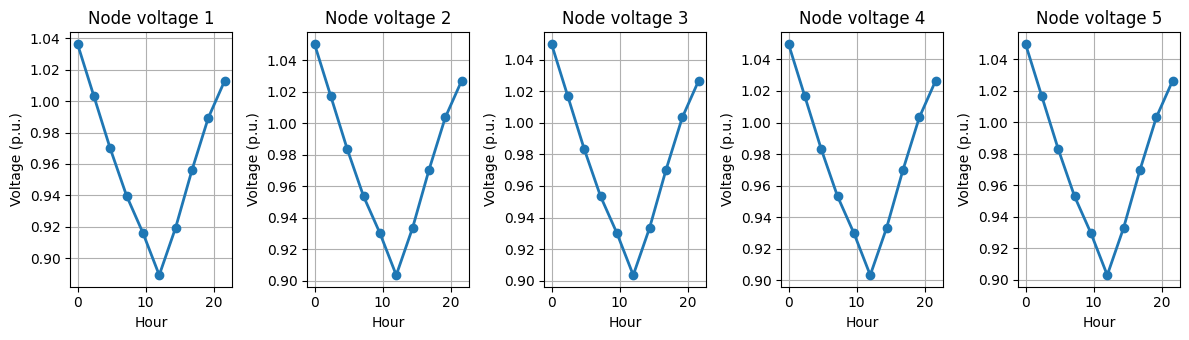

In [15]:
plot_profile(data=output_se["node"]["u_pu"], title="Node voltage", ylabel="Voltage (p.u.)")

# Backup

Install packages if you run into ModuleNotFoundError. Run following command:

In [16]:
# !pip install power-grid-model pandas matplotlib